In [71]:
import numpy as np
import pandas as pd
import scipy.stats as spstats
from scipy import signal
import pickle
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf,acovf

from potentials import potentialRegression
from baselines import construct_ESVM_kernel,split_dataset,set_function,standartize
from optimize import Run_eval_test,optimize_parallel_new
from samplers import MCMC_sampler,Generate_train,ULA
from utils import *

## Setting parameters

<p>Datasets:</p>
<ol>
    <li>Eeg $(N=14\,980,\ d=15)$</li>
    <li>Susy $(N=500\,000,\ d=19)$</li>
</ol>

In [72]:
dataset = "eeg" # Switch between "eeg" and "susy" 

intercept = True # Do we include the intercept

method = {"sampler":"ULA","burn_type":"SGLDFP","main_type":"SGLDFP"} # Sampling method

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
f_type = "posterior_prob_mean"

In [73]:
# Tuning parameters
step = 1*10**(-1)
n_traj_train = 4 # Number of independent MCMC trajectories for train

if (dataset == "eeg"):    
    batch_size = 1*150 # Batch size for stochastic gradient
    N_b = 1*10**4 # Burn-in period
    N_train = 1*10**4 # Length of the train trajectory
    N_test = 1*10**4 # Length of the test trajectories
elif (dataset == "susy"): 
    batch_size = 3*19 # Batch size for stochastic gradient
    N_b = 1*10**4 # Burn in period
    N_train = 1*10**5 # Number of samples on which we optimize
    N_test = 1*10**5 # Number of samples

## Loading data

In [74]:
if (dataset == "eeg"):   
    data = pd.read_csv("data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]    
elif (dataset == "susy"): 
    data = pd.read_csv("data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

## Preprocessing data

In [75]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [76]:
if (f_type == "posterior_mean"):
    X_train,X_train = standartize(X_processed,X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=100,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

### Creating potential

In [77]:
#std of initial point
optim_params = {
    "compute_fp":True,
    "GD":False,
    "stochastic":False,
    "order":1,
    "n_restarts":5,
    "batch_size":100,
    "sigma":1.0,
    "gtol":1e-6,
    "gamma":5e-4,
    "weight_decay":0.995,
    "loop_length":100,
    "n_loops":300
}

In [78]:
# Construct kernel
W_train_spec = construct_ESVM_kernel(N_train)
W_test_spec = construct_ESVM_kernel(N_test)

In [79]:
#Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ = "l",optim_params = optim_params, batch_size = batch_size, print_info = True)
d = Cur_pot.d #dimension

optimization iteration ended
success =  True
func value =  9601.957236447844
jacobian value =  [ 3.84720195e-07 -2.17423610e-07  1.71089491e-07 -4.99160770e-07
  8.14811074e-08  2.04301153e-07 -3.09702874e-07 -5.76749706e-08
 -6.29508846e-08 -1.22053900e-07 -2.06023293e-07 -5.56373771e-07
 -3.37850152e-07  3.53328195e-07 -2.25696455e-07]
number of function evaluation =  22
number of jacobian evaluation =  22
number of optimizer steps =  19
optimization iteration ended
success =  True
func value =  9601.95723644784
jacobian value =  [ 2.81520084e-07 -5.42922468e-08  7.94063255e-08 -3.76091859e-07
 -6.71338640e-08  1.67010425e-07 -1.85732174e-08 -2.18009570e-07
 -3.04285694e-07 -2.35996922e-07 -1.47140961e-07 -4.58626438e-07
 -2.33790638e-07  1.81761745e-07 -4.58773014e-09]
number of function evaluation =  22
number of jacobian evaluation =  22
number of optimizer steps =  19
optimization iteration ended
success =  True
func value =  9601.957236447844
jacobian value =  [ 3.83825027e-07 -

## Sampling training samples

In [80]:
#sample for variance reduction
res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
res = np.asarray(res)
traj,traj_grad = res[:,0,:,:],res[:,1,:,:]

ncores =  4


## Initialization of function values

In [81]:
#Select variables to optimize, other values are available ONLY for "posterior_prob_point" and "posterior_mean"
inds_arr = np.array([0])
#initialize vector of function values
if (f_type == "posterior_mean"):
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
f_vals = set_function(f_type,traj,inds_arr,params)

## Training coefficients for EVM and ESVM

In [82]:
#number of restarts during optimization
n_restarts = 2
#deviation of starting points
sigma = 1
#tolerance (for the norm of gradient)
tol = 1e-5

Here $LS$ estimate corresponds to simple least-squares problem 

In [83]:
A_ESVM_1,A_EVM_1,A_LS_1 = optimize_parallel_new(1,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)

1 degree optimization terminated succesfully
jacobian at termination: 
[ 3.55398407e-06  3.17728678e-06 -3.56641965e-07 -1.56244120e-07
 -1.55557930e-06  1.09988366e-06  2.16446229e-07  2.17817472e-06
  8.97321460e-08  1.10389260e-06  6.53437920e-07  1.13253635e-06
  2.32838009e-06  4.84113355e-06  2.09150728e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[ 5.21712559e-06  3.30786049e-06 -1.96819373e-08 -5.22034899e-07
 -1.75064148e-06  1.09811400e-06  7.26487815e-07  2.48428989e-06
  4.94111632e-07  1.56133320e-06  1.65099037e-06  1.31203501e-06
  3.70418646e-06  5.96004105e-06  2.51359339e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[-6.30664598e-14 -4.42546593e-14 -7.44396779e-14  6.24870910e-14
  8.50378151e-14  7.40528380e-15  3.23004291e-14 -8.57461278e-14
  5.95106375e-15  1.21962371e-13  2.33543958e-14  1.26411222e-14
  2.38782654e-15 -1.16656230e-13  1.83384124e-14]


### Evaluation

Generate $1$ independent test trajectory of the same length with same burn-in, to visualize.

In [84]:
traj_test,traj_grad_test = ULA(1453,Cur_pot,step, N_b, N_test, d,method["burn_type"],method["main_type"])
traj_test = np.asarray([traj_test])
traj_grad_test = np.asarray([traj_grad_test])
f_vals_test = set_function(f_type,traj_test,inds_arr,params)
#

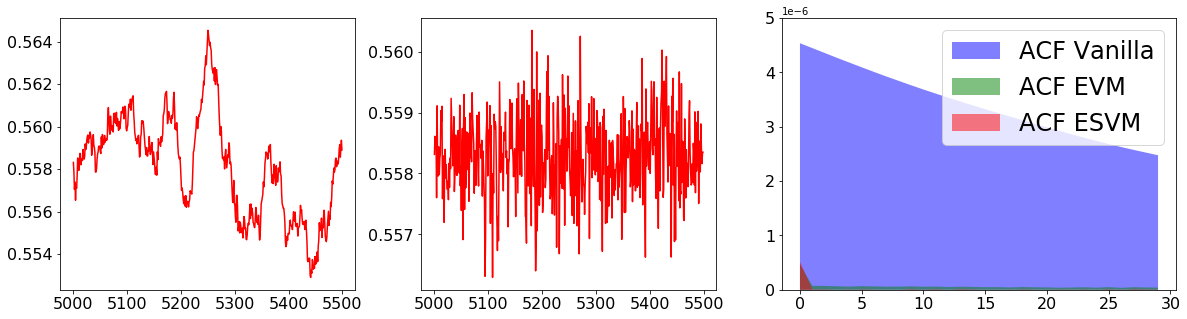

In [85]:
#do main plots in this section
#indices of trajectory and variable, you can play around them in case element-wise test functions
ex_num=0
var_num=0
#part of trajectory tp lot
N1 = 5000
N2 = 5500
#number of covariances to visualize
N_cov_1 = 0
N_cov = 30

vect_vanilla = f_vals_test[ex_num,:,var_num] 
vect_EVM = f_vals_test[ex_num,:,var_num] + traj_grad_test[ex_num,:,:] @ A_EVM_1[var_num,:]
vect_ESVM = f_vals_test[ex_num,:,var_num] + traj_grad_test[ex_num,:,:] @ A_ESVM_1[var_num,:]

sample_acf_vanilla = acovf(vect_vanilla, unbiased = True,fft = True)#,nlags=100)
sample_acf_EVM = acovf(vect_EVM, unbiased = True,fft = True)#,nlags=100)
sample_acf_ESVM = acovf(vect_ESVM, unbiased = True,fft = True)#,nlags=100)
#"""

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5),gridspec_kw={'width_ratios': [1.5,1.5,2]})
#ax1.set_title('Vanilla trajectory',fontsize=24)
ax1.plot(N1+np.arange(len(vect_vanilla[N1:N2])),vect_vanilla[N1:N2],color='r')
ax1.tick_params(axis='y',labelsize = 16)
ax1.tick_params(axis='x',labelsize = 16)
#ax2.set_title('Trajectory after ESVM',fontsize=24)
ax2.plot(N1+np.arange(len(vect_ESVM[N1:N2])),vect_ESVM[N1:N2],color='r')
ax2.tick_params(axis='y',labelsize = 16)
ax2.tick_params(axis='x',labelsize = 16)
#ax3.set_title('Sample autocovariance',fontsize=24)
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_vanilla[N_cov_1:N_cov],facecolor='blue',alpha=0.5,label='ACF Vanilla')
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_EVM[N_cov_1:N_cov],facecolor='green',alpha=0.5,label='ACF EVM')
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_ESVM[N_cov_1:N_cov],facecolor='red',alpha=0.5,label='ACF ESVM')
ax3.set_ylim(0,5e-6)
ax3.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
ax3.tick_params(axis='y',labelsize = 16)
ax3.tick_params(axis='x',labelsize = 16)
ax3.legend(fontsize=24)
fig.savefig("adjusted_trajectories.pdf",bbox_inches = "tight")
plt.show()

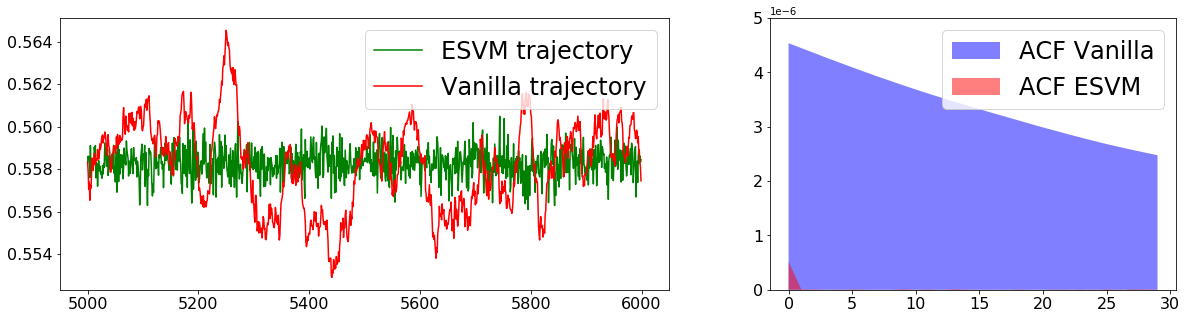

In [102]:
#do main plots in this section
#indices of trajectory and variable, you can play around them in case element-wise test functions
ex_num=0
var_num=0
#part of trajectory tp lot
N1 = 5000
N2 = 6000
#number of covariances to visualize
N_cov_1 = 0
N_cov = 30

vect_vanilla = f_vals_test[ex_num,:,var_num] 
vect_EVM = f_vals_test[ex_num,:,var_num] + traj_grad_test[ex_num,:,:] @ A_EVM_1[var_num,:]
vect_ESVM = f_vals_test[ex_num,:,var_num] + traj_grad_test[ex_num,:,:] @ A_ESVM_1[var_num,:]

sample_acf_vanilla = acovf(vect_vanilla, unbiased = True,fft = True)#,nlags=100)
sample_acf_EVM = acovf(vect_EVM, unbiased = True,fft = True)#,nlags=100)
sample_acf_ESVM = acovf(vect_ESVM, unbiased = True,fft = True)#,nlags=100)
#"""

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5),gridspec_kw={'width_ratios': [3,2]})
#ax1.set_title('Vanilla trajectory',fontsize=24)
ax1.plot(N1+np.arange(len(vect_ESVM[N1:N2])),vect_ESVM[N1:N2],color='g', label = 'ESVM trajectory')
ax1.plot(N1+np.arange(len(vect_vanilla[N1:N2])),vect_vanilla[N1:N2],color='r', label = 'Vanilla trajectory')
ax1.tick_params(axis='y',labelsize = 16)
ax1.tick_params(axis='x',labelsize = 16)
ax1.legend(fontsize=24)


#ax3.set_title('Sample autocovariance',fontsize=24)
ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_vanilla[N_cov_1:N_cov],facecolor='blue',alpha=0.5,label='ACF Vanilla')
#ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_EVM[N_cov_1:N_cov],facecolor='green',alpha=0.5,label='ACF EVM')
ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_ESVM[N_cov_1:N_cov],facecolor='red',alpha=0.5,label='ACF ESVM')
ax2.set_ylim(0,5e-6)
ax2.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
ax2.tick_params(axis='y',labelsize = 16)
ax2.tick_params(axis='x',labelsize = 16)
ax2.legend(fontsize=24)
fig.savefig("adjusted_trajectories_batch_150.pdf",bbox_inches = "tight")
plt.show()

### Produce 3 plots in a row

In [87]:
method = {"sampler":"ULA","burn_type":"SGLDFP","main_type":"SGLDFP"} # Sampling method
# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
f_type = "posterior_prob_mean"

In [88]:
inds_arr = np.array([0])
params = {"X":X_test,"Y":Y_test}

In [89]:
def generate_function_coefs(batch_size): 
    Cur_pot = potentialRegression(Y_train, X_train, typ = "l",optim_params = optim_params, batch_size = batch_size, print_info = True)
    d = Cur_pot.d
    res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
    f_vals = set_function(f_type,traj,inds_arr,params)
    #number of restarts during optimization
    n_restarts = 2
    #deviation of starting points
    sigma = 4.0
    #tolerance (norm of gradient needed to terminate)
    tol = 1e-5
    #optimization
    A_ESVM_1,A_EVM_1,A_LS_1 = optimize_parallel_new(1,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)
    traj,traj_grad = ULA(1453,Cur_pot,step, N_b, N_test, d, method["burn_type"],method["main_type"])
    traj = np.asarray([traj])
    traj_grad = np.asarray([traj_grad])
    f_vals_test = set_function(f_type,traj,inds_arr,params)
    return f_vals_test,traj_grad,A_ESVM_1,A_EVM_1   

For batch sizes $5$, $15$ and $50$ 

In [94]:
f_vals_5,traj_grad_5,A_ESVM_5,A_EVM_5 = generate_function_coefs(batch_size=5)
f_vals_15,traj_grad_15,A_ESVM_15,A_EVM_15 = generate_function_coefs(batch_size=15)
f_vals_150,traj_grad_150,A_ESVM_150,A_EVM_150 = generate_function_coefs(batch_size=50)

optimization iteration ended
success =  True
func value =  9601.957236447844
jacobian value =  [ 3.84720195e-07 -2.17423610e-07  1.71089491e-07 -4.99160770e-07
  8.14811074e-08  2.04301153e-07 -3.09702874e-07 -5.76749706e-08
 -6.29508846e-08 -1.22053900e-07 -2.06023293e-07 -5.56373771e-07
 -3.37850152e-07  3.53328195e-07 -2.25696455e-07]
number of function evaluation =  22
number of jacobian evaluation =  22
number of optimizer steps =  19
optimization iteration ended
success =  True
func value =  9601.95723644784
jacobian value =  [ 2.81520084e-07 -5.42922468e-08  7.94063255e-08 -3.76091859e-07
 -6.71338640e-08  1.67010425e-07 -1.85732174e-08 -2.18009570e-07
 -3.04285694e-07 -2.35996922e-07 -1.47140961e-07 -4.58626438e-07
 -2.33790638e-07  1.81761745e-07 -4.58773014e-09]
number of function evaluation =  22
number of jacobian evaluation =  22
number of optimizer steps =  19
optimization iteration ended
success =  True
func value =  9601.957236447844
jacobian value =  [ 3.83825027e-07 -

1 degree optimization terminated succesfully
jacobian at termination: 
[ 1.47480630e-06 -2.00975398e-07  3.18435932e-06  1.79652351e-06
 -3.42412141e-07 -8.97170371e-07 -1.24131993e-06 -1.41668491e-06
 -1.04582783e-06  5.05702776e-07 -1.25301923e-06 -5.87791776e-07
 -1.52222281e-06 -2.13663025e-06  6.12575558e-07]1 degree optimization terminated succesfully

jacobian at termination: 
[ 2.03036876e-06  4.70237291e-07  3.60828677e-06  2.35273481e-06
 -3.58692936e-07 -1.11463408e-06 -2.82476751e-06 -1.45077657e-06
 -2.34768339e-06  8.79184458e-07 -7.88538365e-07 -4.67761324e-07
 -1.27834611e-06 -2.05113853e-06  2.95564926e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[-1.57257829e-12 -4.64208216e-12 -4.21116640e-12  6.31744754e-12
  7.41287807e-13  7.61306084e-12 -4.44899201e-12  7.88780469e-12
 -1.38313441e-12  7.90921446e-12  2.98398307e-12 -1.66121476e-12
 -2.66623547e-12 -2.01523199e-13 -4.82725147e-13]


In [95]:
def get_func_values(f_vals,traj_grad,EVM_coef,ESVM_coef, ex_num=0,var_num=0):
    vect_vanilla = f_vals[ex_num,:,var_num] 
    vect_EVM = f_vals[ex_num,:,var_num] + traj_grad[ex_num,:,:] @ EVM_coef[var_num,:]
    vect_ESVM = f_vals[ex_num,:,var_num] + traj_grad[ex_num,:,:] @ ESVM_coef[var_num,:]
    return vect_vanilla,vect_EVM,vect_ESVM 

In [96]:
def get_acfs(f_vals,f_vals_EVM,f_vals_ESVM,nlags = 100,ex_num=0,var_num=0):
    sample_acf_vanilla = acovf(f_vals, unbiased = True,fft = True)#,nlags=nlags)
    sample_acf_EVM = acovf(f_vals_EVM, unbiased = True,fft = True)#,nlags=nlags)
    sample_acf_ESVM = acovf(f_vals_ESVM, unbiased = True,fft = True)#,nlags=nlags)
    return sample_acf_vanilla,sample_acf_EVM,sample_acf_ESVM

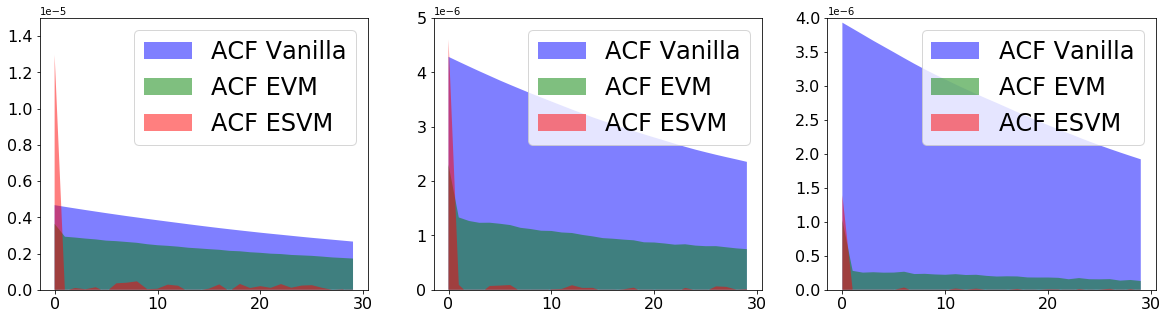

In [100]:
#number of covariances to visualize
N_cov_1 = 0
N_cov = 30

vect_vanilla_5,vect_EVM_5,vect_ESVM_5 = get_func_values(f_vals_5,traj_grad_5,A_EVM_5,A_ESVM_5)
vect_vanilla_15,vect_EVM_15,vect_ESVM_15 = get_func_values(f_vals_15,traj_grad_15,A_EVM_15,A_ESVM_15)
vect_vanilla_150,vect_EVM_150,vect_ESVM_150 = get_func_values(f_vals_150,traj_grad_150,A_EVM_150,A_ESVM_150)

sample_acf_vanilla_5,sample_acf_EVM_5,sample_acf_ESVM_5 = get_acfs(vect_vanilla_5,vect_EVM_5,vect_ESVM_5)
sample_acf_vanilla_15,sample_acf_EVM_15,sample_acf_ESVM_15 = get_acfs(vect_vanilla_15,vect_EVM_15,vect_ESVM_15)
sample_acf_vanilla_150,sample_acf_EVM_150,sample_acf_ESVM_150 = get_acfs(vect_vanilla_150,vect_EVM_150,vect_ESVM_150)


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5),gridspec_kw={'width_ratios': [1,1,1]})
#ax1.set_title('Batch size = 5',fontsize=24)
ax1.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_vanilla_5[N_cov_1:N_cov],facecolor='blue',alpha=0.5,label='ACF Vanilla')
ax1.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_EVM_5[N_cov_1:N_cov],facecolor='green',alpha=0.5,label='ACF EVM')
ax1.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_ESVM_5[N_cov_1:N_cov],facecolor='red',alpha=0.5,label='ACF ESVM')
ax1.set_ylim(0,15e-6)
ax1.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
ax1.tick_params(axis='y',labelsize = 16)
ax1.tick_params(axis='x',labelsize = 16)
ax1.legend(fontsize=24)
#ax2.set_title('Batch size = 10',fontsize=24)
ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_vanilla_15[N_cov_1:N_cov],facecolor='blue',alpha=0.5,label='ACF Vanilla')
ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_EVM_15[N_cov_1:N_cov],facecolor='green',alpha=0.5,label='ACF EVM')
ax2.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_ESVM_15[N_cov_1:N_cov],facecolor='red',alpha=0.5,label='ACF ESVM')
ax2.set_ylim(0,5e-6)
ax2.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
ax2.tick_params(axis='y',labelsize = 16)
ax2.tick_params(axis='x',labelsize = 16)
ax2.legend(fontsize=24)
#ax3.set_title('Batch size = 50',fontsize=24)
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_vanilla_150[N_cov_1:N_cov],facecolor='blue',alpha=0.5,label='ACF Vanilla')
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_EVM_150[N_cov_1:N_cov],facecolor='green',alpha=0.5,label='ACF EVM')
ax3.fill_between(N_cov_1+np.arange(N_cov-N_cov_1),sample_acf_ESVM_150[N_cov_1:N_cov],facecolor='red',alpha=0.5,label='ACF ESVM')
ax3.set_ylim(0,4e-6)
ax3.tick_params(axis='y',labelsize = 16)
ax3.tick_params(axis='x',labelsize = 16)
ax3.ticklabel_format(axis='y',style='sci',scilimits=(-2,2))
ax3.legend(fontsize=24)
fig.savefig("all_batches_new.pdf",bbox_inches = "tight")
plt.show()